In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import os
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv('../config.env')

# Access the environment variable
api_key = os.getenv('MLFINLAB_API_KEY')
if api_key is None:
    raise ValueError("MLFINLAB_API_KEY not found in your environment variables.")
else:
    print("MLFINLAB_API_KEY is set correctly.")


MLFINLAB_API_KEY is set correctly.


In [3]:
# Import MlFinLab tools
import mlfinlab
from mlfinlab.multi_product.etf_trick import get_futures_roll_series

In [4]:
# Import data
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/futures_stitched.csv"
aggregated_df = pd.read_csv(url, index_col = 0, parse_dates = [0])


In [7]:
# viewing head of the data

aggregated_df.head(10)

,close,open,high,low,volume,ticker,nearest_contract
date,,,,,,,
2021-01-04,255.44,254.60,258.80,254.6,2146.0,G_2021,G_2021
2021-01-05,247.86,251.00,251.00,246.3,3524.0,G_2021,G_2021
2021-01-06,247.38,247.80,248.68,247.2,2614.0,G_2021,G_2021
2021-01-07,255.40,250.00,257.00,250.0,2492.0,G_2021,G_2021
2021-01-08,258.76,259.48,262.30,258.7,1998.0,G_2021,G_2021
2021-01-11,262.60,263.00,265.40,261.0,2590.0,G_2021,G_2021
2021-01-12,273.30,264.00,277.00,263.0,4754.0,G_2021,G_2021
2021-01-13,262.66,269.00,270.50,261.5,5382.0,G_2021,G_2021
2021-01-14,260.30,262.00,265.20,257.7,3412.0,G_2021,G_2021


In [9]:
# viewing tail of the data

aggregated_df.tail(10)

,close,open,high,low,volume,ticker,nearest_contract
date,,,,,,,
2022-09-16,895.00,950.0,962.00,883.98,1952.0,V_2022,V_2022
2022-09-19,854.18,870.0,870.02,818.00,1592.0,V_2022,V_2022
2022-09-20,851.90,790.0,900.00,790.00,2724.0,V_2022,V_2022
2022-09-21,891.74,930.0,960.00,846.00,2656.0,V_2022,V_2022
2022-09-22,881.22,842.0,901.88,840.00,2940.0,V_2022,V_2022
2022-09-23,824.28,850.0,866.00,820.00,2602.0,V_2022,V_2022
2022-09-26,804.00,787.0,816.00,780.00,1846.0,V_2022,V_2022
2022-09-27,831.18,810.0,922.00,808.00,3334.0,V_2022,V_2022
2022-09-28,878.06,910.0,920.00,852.00,2530.0,V_2022,V_2022


## Creating Continuous Futures Contracts

In [10]:
# Get roll gaps (absolute and relative)
roll_gaps_absolute = get_futures_roll_series(aggregated_df, open_col='open', close_col='close',
                                             sec_col='ticker', current_sec_col='nearest_contract', method='absolute')

roll_gaps_relative = get_futures_roll_series(aggregated_df, open_col='open', close_col='close',
                                             sec_col='ticker', current_sec_col='nearest_contract', method='relative')


In [11]:
# Filter out rows where there is a roll (a change in nearest contract)
# This forms the basis of the continuous contract
continuous_contract = aggregated_df[aggregated_df.ticker == aggregated_df.nearest_contract]
continuous_contract.head()

,close,open,high,low,volume,ticker,nearest_contract
date,,,,,,,
2021-01-04,255.44,254.60,258.80,254.6,2146.0,G_2021,G_2021
2021-01-05,247.86,251.00,251.00,246.3,3524.0,G_2021,G_2021
2021-01-06,247.38,247.80,248.68,247.2,2614.0,G_2021,G_2021
2021-01-07,255.40,250.00,257.00,250.0,2492.0,G_2021,G_2021
2021-01-08,258.76,259.48,262.30,258.7,1998.0,G_2021,G_2021


#### Subtract or divide the gaps from close prices. This depends on if you are using the absolute or relative method.

In [12]:
# Make a copy of the first contract
continuous_contract_absolute_method = continuous_contract.copy()
continuous_contract_relative_method = continuous_contract.copy()

# Apply the roll gaps
continuous_contract_absolute_method['close'] -= roll_gaps_absolute
continuous_contract_relative_method['close'] /= roll_gaps_relative

#### Plot nearest continuous futures contract the using different fill methods.

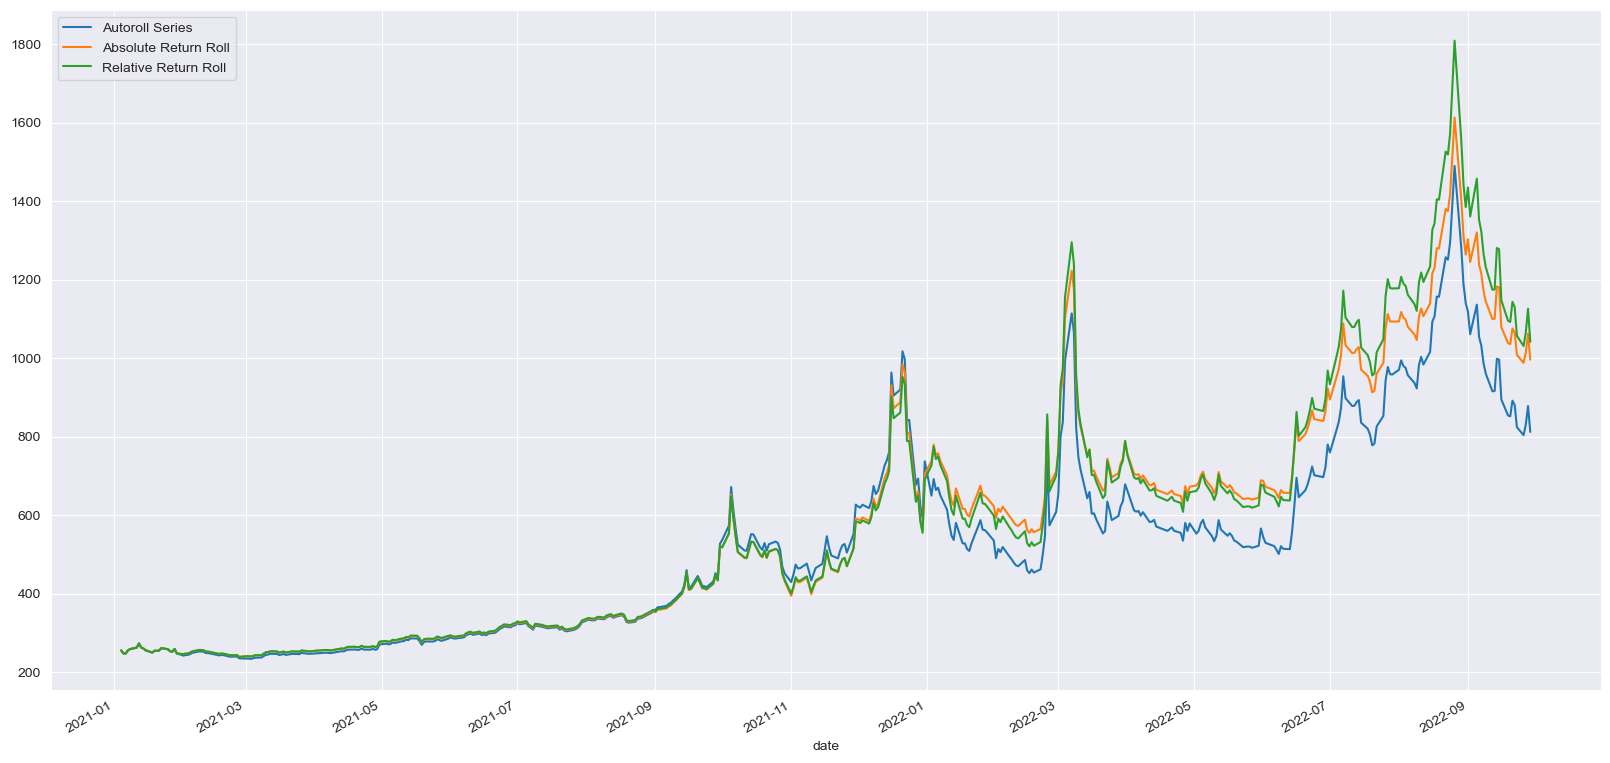

In [13]:
# Plot
plt.figure(figsize=(20, 10))
continuous_contract.close.plot(label = 'Autoroll Series')
continuous_contract_absolute_method.close.plot(label = 'Absolute Return Roll')
continuous_contract_relative_method.close.plot(label = 'Relative Return Roll')
plt.legend(loc='best')
plt.show()

## Conclusion

As you can see, accounting for the differences in contract prices can be quite substantial, by not accounting for it you add additional noise to the model.

### Notes from the book:

"Rolled prices are used for simulating PnL and portfolio mark-to-market values. However, raw prices should still be used to size positions and determine capital consumption. Keep in mind, rolled prices can indeed become negative, particularly in futures contracts that sold off while in contango." (pg 37, AFML)

- Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 37-38.